# Azure Connection for the data base.


## issue: Blobs DB does not have an inherent indices system.

In [152]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__
import os
from datetime import datetime
import time
import shutil
import cv2
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import glob,re
from itertools import combinations, product
import math

%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
local_dir = './d1'

if not os.path.exists(local_dir): os.makedirs(local_dir)

In [4]:
shutil.rmtree(local_dir) #delete directory

In [5]:
# Azure connecting info. 
os.environ['AZURE_STORAGE_CONNECTION_STRING'] = 'DefaultEndpointsProtocol=https;AccountName=blobsdb;AccountKey=tJK43kihAcaeZMjcegWFcyg8tsFmOr9f2Kn8q6NUinVSJW5O3jymYbjaiGBjmx8Ibq5LsBVPcABvYeV+tUCPnQ==;EndpointSuffix=core.windows.net'
connect_str = os.getenv('AZURE_STORAGE_CONNECTION_STRING')
# Create the BlobServiceClient object which will be used to create a container client.
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

In [6]:
def retrieve_last_k_containers(k):
    
    "function retrieve last k containers from Azure Blobs Storage"

    container_list=[]
    # list containers
    for i,item in enumerate(reversed(list(blob_service_client.list_containers()))):
        if i ==k:
            break
        print(datetime.fromtimestamp(int(item["name"].split("-")[0])))
        container_list.append(item["name"])
    return container_list

In [7]:
container_list=retrieve_last_k_containers(5)

2021-12-01 15:59:39
2021-12-01 15:42:40
2021-12-01 15:25:41
2021-12-01 15:08:43
2021-12-01 14:51:44


# Download files - blobs

In [8]:
def dl_blobs_to_local(container_list):
    for container in container_list:
        dir_name = local_dir + "/" + container
        os.makedirs(dir_name)
        container_client = blob_service_client.get_container_client(container)
        for blob in container_client.list_blobs():
            save_blob(blob.name,dir_name,container_client)
            
            
def save_blob(blob_name,dir_name,container_client):
    
    "function downloads and saves one blob"
    
    with open(dir_name+"/"+ str(blob_name), "wb") as my_blob:
        blob_client = container_client.get_blob_client(blob_name) # Instantiate a new BlobClient
        download_stream = blob_client.download_blob()
        my_blob.write(download_stream.readall())

In [9]:
#shutil.rmtree(local_dir) #delete directory

In [10]:
dl_blobs_to_local(container_list) # download

# Masking 
## how to mask the raspberry HQ camera output:

A.Pre Defined masking - Not good because every change in the setup requires retuning the mask parameters. 

B. Masking by motion detection, use image substraction, this approach we will try here. see below.

C. NN that object detects the desired object in the picture and set boundaries. (mask R-CNN and like)

## Original masking function (option A)

In [11]:
def mask_images(img_path, erode_func, output_lib, params, output_ext=".jpg"):
   

    """:param img_path: string, path to the image.
       :param erode_func: function, masking function.
       :param output_lib: string, path to output directory.
       :param output_ext: string, type of output image, default jpg.
       :param params: dictionary mask- parameters.

       :returns np.arrays of g_img, mask_g and img

       """

    # set cropping and masking parameters:
    hlc, hrc, vlc, vuc = params["hlc"], params["hrc"], params["vlc"], params["vuc"]
    n, n_iter = params["n"], params["n_iter"]

    # extract img name:
    img_name = os.path.splitext(Path(img_path).name)[0]

    # output name
    g_img_path = output_lib + '/' + 'gr_' + img_name + output_ext  # output path to g_img

    img = cv2.imread(img_path)[vlc:vuc, hlc:hrc]  # cv2 read & crop
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # convert to hsv
    mask = cv2.inRange(hsv, (35, 25, 25), (80, 255, 255))  # mask by slicing the green spectrum
    # mask = cv2.inRange(hsv, (0, 42, 0), (179, 255, 255)) # everything except white

    # apply the masking:
    imask = mask > 0
    g_img = np.zeros_like(img, np.uint8)
    mask_g = np.zeros_like(img, np.uint8)

    # make white background
    g_img.fill(255)
    g_img[imask] = img[imask]
    mask_g[~imask] = img[~ imask]
    mask_g[mask_g != 0] = 255

    # erosion
    g_img, mask, img = erode_func(img, mask_g, n, n_iter)

    # save to directory
    cv2.imwrite(g_img_path, g_img)

    return g_img, mask, img

# Motion Detection (option B)

In [14]:
img1 = "./d1/1638370779-13795/52img0-87.jpg"
img2 = "./d1/1638370779-13795/52img1-38.jpg"
img3 = "./d1/1638370779-13795/52img1-86.jpg"

In [85]:
im1 = cv2.imread(img1)
im2 = cv2.imread(img2)
im3 = cv2.imread(img3)

im1_np = np.int32(im1)
im2_np = np.int32(im2)
im3_np = np.int32(im3)

im13_np=cv2.subtract(im1_np,im3_np)
im23_np=cv2.subtract(im2_np,im3_np)
im12_np=cv2.subtract(im1_np,im2_np)

gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
gray3 = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)

gray12=cv2.subtract(gray1,gray2)
gray13=cv2.subtract(gray1,gray3)
gray23=cv2.subtract(gray2,gray3)

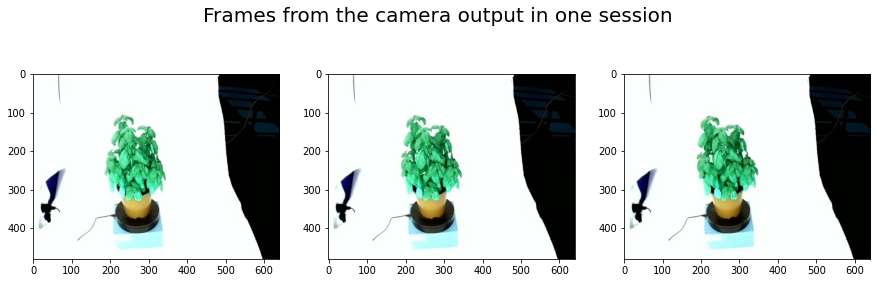

In [91]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15,15))
fig.suptitle('Frames from the camera output in one session', fontsize=20,y=0.65)
axs[0].imshow(im1);
axs[1].imshow(im2);
axs[2].imshow(im3);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


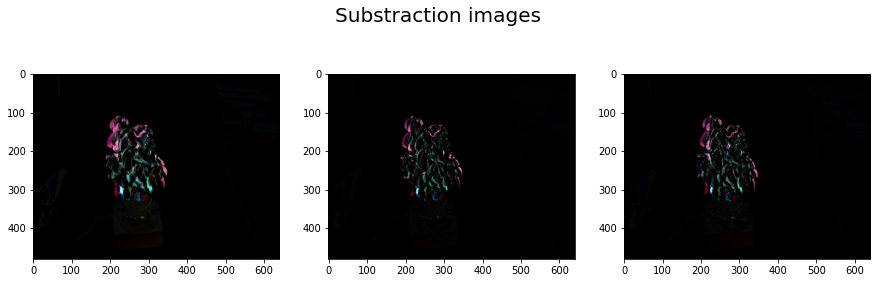

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15,15))
fig.suptitle('Substraction images', fontsize=20,y=0.65)
axs[0].imshow(im13_np);
axs[1].imshow(im23_np);
axs[2].imshow(im12_np);

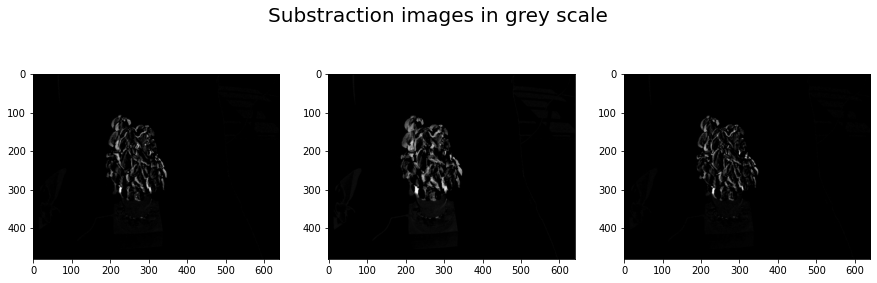

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15,15))
fig.suptitle('Substraction images in grey scale', fontsize=20,y=0.65)
axs[0].imshow(gray12, cmap=plt.cm.binary_r);
axs[1].imshow(gray13, cmap=plt.cm.binary_r);
axs[2].imshow(gray23, cmap=plt.cm.binary_r);

In [23]:
def derivative(series, interval=1):
    """interval-lag auxiliary
        :parameters: 
                    dataset (DataFrame)
                    intervel (int)
        :returns: 
                    DataFrame of (intervel)-Lag."""
    
    diff = list()
    for i in range(len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)
    return np.array(diff)

def find_crop_indices(img_diff):

    
    def find_turning_pts(M,interval):
    
        left=[]
        right=[]
    
        for t in range(interval,len(M)):
            if M[t] != 0:
                for j in range(1,interval+1):
                    if M[t-j] !=0:
                        break
                if j == interval:
                    left.append(t)
                
                
        for t in range(0, len(M)-interval):
            if M[t] != 0:
                for j in range(1,interval+1):
                    if M[t+j] !=0:
                        break
                if j == interval:
                    right.append(t)
        return [0]+left+[len(M)],[0]+right+[len(M)]
    
    #reduce img to vertical mean vector
    M = img_diff.mean(axis=0)
    
    #compute median for clipping
    M_median = (M.max()-M.min())/2
    
    #aux clipper
    clip = lambda t : 0 if t-M_median < 0 else t 
    
    #apply on mean vec on M
    M_mod = np.array([clip(t) for t in M])
    
    #find suspected points for the main objects' boundaries
    right,left = find_turning_pts(abs(derivative(M_mod)),50) 
    
    #compute the biggest component 
    ind_max=np.argmax(list(map(int.__sub__, left, right)))
    
    # safety intervel to be added
    M_safe=100
    crop_interval= (max(0,right[ind_max]-M_safe),min(len(M_mod),left[ind_max]+M_safe)) 
    
    hlc,hrc = crop_interval
    return hlc,hrc


def find_turning_pts(M,interval):
    
    left=[]
    right=[]
    
    for t in range(interval,len(M)):
        if M[t] != 0:
            for j in range(1,interval+1):
                if M[t-j] !=0:
                    break
            if j == interval:
                left.append(t)
                
                
                
    for t in range(0, len(M)-interval):
        if M[t] != 0:
            for j in range(1,interval+1):
                if M[t+j] !=0:
                    break
            if j == interval:
                right.append(t)
    
    
    return [0]+left+[len(M)],[0]+right+[len(M)]

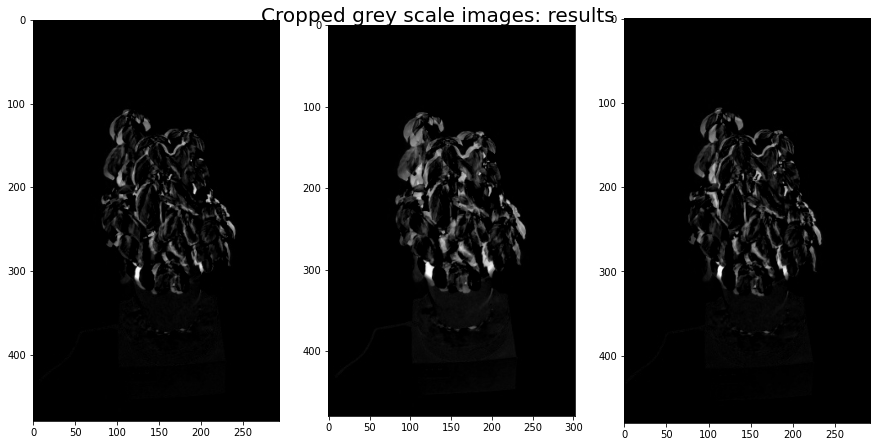

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15,15))
fig.suptitle('Cropped grey scale images: results', fontsize=20,y=0.7)

l,r = find_crop_indices(gray23)
axs[0].imshow(gray23[:,l:r], cmap=plt.cm.binary_r);
l,r = find_crop_indices(gray13)
axs[1].imshow(gray13[:,l:r], cmap=plt.cm.binary_r);
l,r = find_crop_indices(gray12)
axs[2].imshow(gray12[:,l:r], cmap=plt.cm.binary_r);

# analysis (Explicit)

## vertical mean (axis = 0)

In [29]:
M=gray23.mean(axis=0)

M_median=(M.max()-M.min())/2

clip = lambda t : 0 if t-M_median < 0 else t

M_mod = np.array([clip(t) for t in M])

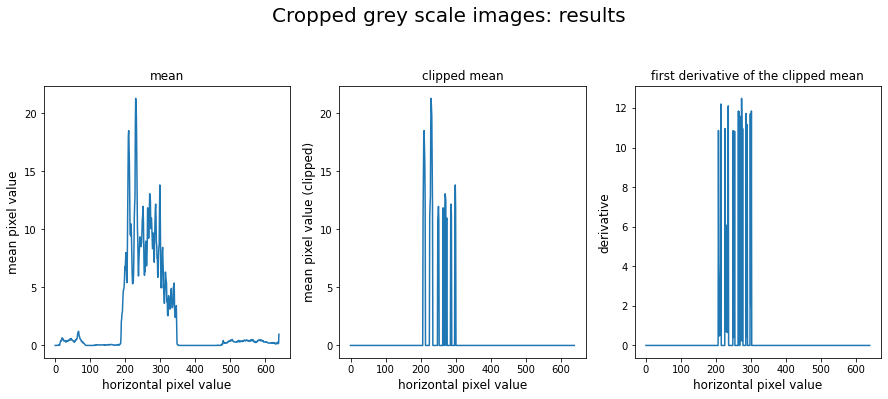

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
fig.suptitle('Cropped grey scale images: results', fontsize=20,y=1.1)

axs[0].plot(M);
axs[0].set_title("mean");
axs[0].set_xlabel('horizontal pixel value', fontsize=12);
axs[0].set_ylabel('mean pixel value', fontsize=12);

axs[1].plot(M_mod);
axs[1].set_title("clipped mean");
axs[1].set_xlabel('horizontal pixel value', fontsize=12);
axs[1].set_ylabel('mean pixel value (clipped)', fontsize=12);


axs[2].plot(abs(derivative(M_mod)));
axs[2].set_title("first derivative of the clipped mean");
axs[2].set_xlabel('horizontal pixel value', fontsize=12);
axs[2].set_ylabel('derivative', fontsize=12);

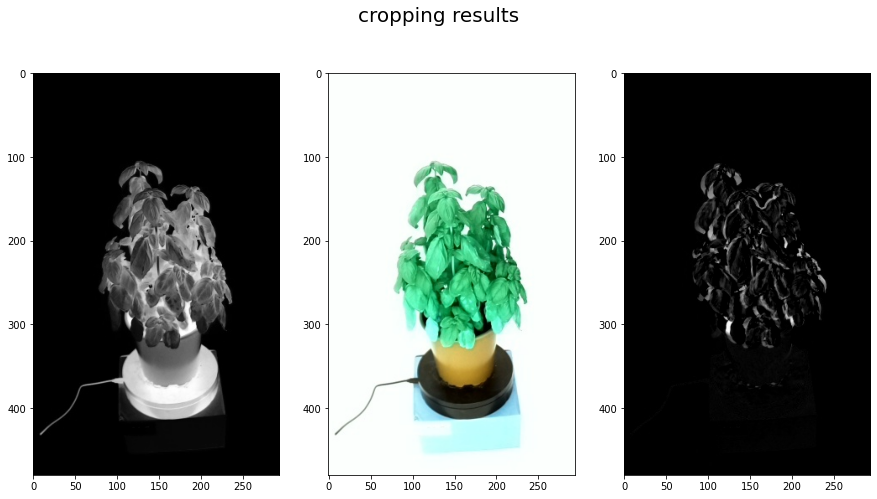

In [31]:
# search for horizontal cropping interval by taking derivative.
right,left=find_turning_pts(abs(derivative(M_mod)),50)

# taking difference of l/r jumping points found in right,left
moving_int_size=list(map(int.__sub__, left, right))

#print(moving_int_size)

# biggest interval
ind_max=np.argmax(moving_int_size)

#safety enlarge the found-before cropping interval.
M=100
hlc,hrc= (max(0,right[ind_max]-M),min(len(M_mod),left[ind_max]+M))

#print(hlc,hrc)

#plotting results

fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15,15))
fig.suptitle('cropping results', fontsize=20,y=0.75)
axs[0].imshow(gray1[:, hlc:hrc], cmap=plt.cm.binary);

axs[1].imshow(im1[:, hlc:hrc]);

axs[2].imshow(gray23[:, hlc:hrc], cmap=plt.cm.binary_r);


## horizontal mean (axis = 1)

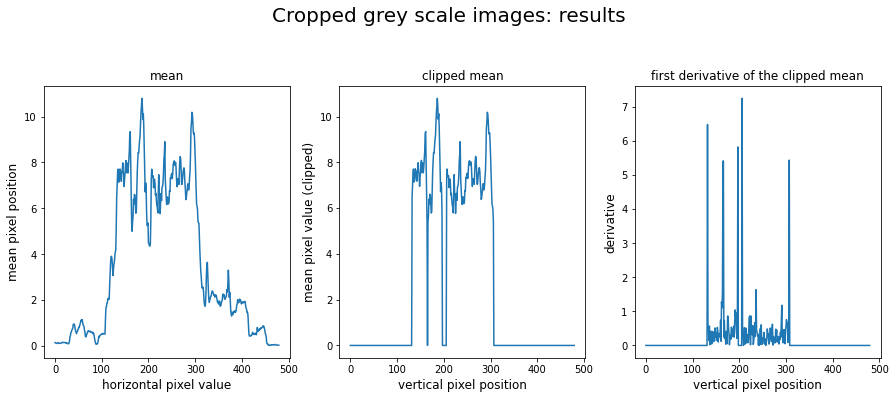

In [32]:
M=gray13.mean(axis=1)

M_median=(M.max()-M.min())/2

clip = lambda t : 0 if t-M_median < 0 else t

M_mod = np.array([clip(t) for t in M])


fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
fig.suptitle('Cropped grey scale images: results', fontsize=20,y=1.1)

axs[0].plot(M);
axs[0].set_title("mean");
axs[0].set_xlabel('horizontal pixel value', fontsize=12);
axs[0].set_ylabel('mean pixel position', fontsize=12);

axs[1].plot(M_mod);
axs[1].set_title("clipped mean");
axs[1].set_xlabel('vertical pixel position', fontsize=12);
axs[1].set_ylabel('mean pixel value (clipped)', fontsize=12);


axs[2].plot(abs(derivative(M_mod)));
axs[2].set_title("first derivative of the clipped mean");
axs[2].set_xlabel('vertical pixel position', fontsize=12);
axs[2].set_ylabel('derivative', fontsize=12);

In [60]:
container_path = "./d1/1638370779-13795"

def organize_container(container_path):
    
    files = [file.split("/")[-1] for file in glob.glob(container_path+"/*")]
    cameras = list(set([file[0:2] for file in files]))
    d={}
    
    # dict init
    for cam in cameras:
        d[cam]=[]
    for file in files:
        d[file[0:2]].append(container_path+"/"+file)
    for cam in cameras:
        d[cam]=sorted(d[cam])
            
    return d

result_dict = {}
def crop_session(d):
    
    def compute_diffs(im1,im2,im3):
        return [cv2.subtract(im2,im1),cv2.subtract(im3,im2)]
 
    cameras = list(d.keys())
    d_grey={}
    
    for cam in cameras:  
        grey = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY) for img in d[cam]]
        img_inds = [x for x in range(len(grey))]
        
        for ind in img_inds:
            diff_ind = list(np.argsort([abs(x - ind) for x in [x for x in range(len(grey))]] )[:3])
            d_im1,d_im2 = compute_diffs(grey[diff_ind[1]],grey[diff_ind[0]],grey[diff_ind[2]])
            
            hl1,hr1 = find_crop_indices(d_im1)
            hl2,hr2 = find_crop_indices(d_im2)
            
            hlc,hrc= min(hl1,hl2),max(hr1,hr2)
            
            #print(d[cam][ind])
            result_dict[d[cam][ind]] = (hlc,hrc)
            
    return result_dict 

# plot cropping results:

Text(0.5, 1, 'cropping results')

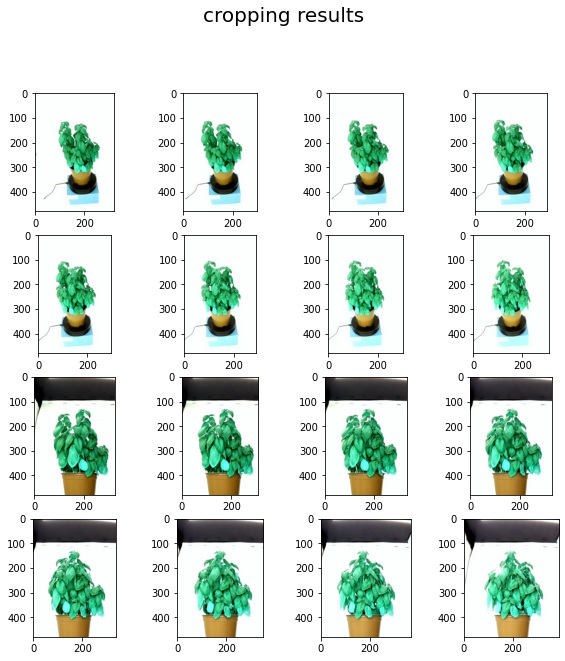

In [170]:
d = organize_container(container_path);
N = int(math.ceil(math.sqrt(len([item for sublist in list(d.values()) for item in sublist]))))
dict_w_crop = crop_session(d);

fig, axs = plt.subplots(nrows=N, ncols=N,figsize=(10,10));
fig.suptitle('cropping results', fontsize=20,y=1);

for i,j in product(range(N),range(N)):
    
    img, crop = dict_w_crop.popitem();
    hl,hr = crop;
    axs[i,j].imshow(cv2.imread(img)[:,hl:hr]);

'./d1/1638370779-13795/56img0-87.jpg'

In [185]:
img_path =list(crop_session(d).items())[5][0]
hlc,hrc=list(crop_session(d).items())[5][1]

img = cv2.imread(img_path)[:, hlc:hrc]  # cv2 read & crop

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # convert to hsv

mask = cv2.inRange(hsv, (35, 25, 25), (80, 255, 255))  # mask by slicing the green spectrum
# mask = cv2.inRange(hsv, (0, 42, 0), (179, 255, 255)) # everything except white

# apply the masking:
imask = mask > 0
g_img = np.zeros_like(img, np.uint8)
mask_g = np.zeros_like(img, np.uint8)

# make white background
g_img.fill(255)
g_img[imask] = img[imask]
mask_g[~imask] = img[~ imask]
mask_g[mask_g != 0] = 255

# erosion
#g_img, mask, img = erode_func(img, mask_g, n, n_iter)

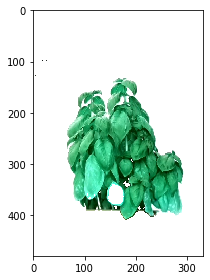

In [186]:
imshow(g_img)

# COLMAP